# R-VGA for logistic regression

$$
\begin{aligned}
    \mu_t &= \mu_{t-1} + P_{t-1}\left( y_t - \mathbb{E}\left[\sigma(\theta^\intercal{\bf x}_t\right] \right){\bf x}_t\\
    P_{t}^{-1} &= P_{t-1}^{-1} - \mathbb{E}\left[\sigma'\left(\theta^\intercal {\bf x}_t\right)\right] x_tx_t^\intercal
\end{aligned}
$$

In [14]:
import jax
import chex
import distrax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from functools import partial

In [15]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

In [316]:
key = jax.random.PRNGKey(31)
key_params, key_train, key_test = jax.random.split(key, 3)

In [329]:
@chex.dataclass
class Params:
    mean: jnp.DeviceArray
    prec: jnp.DeviceArray

def sample_true_params(key, d, c=1.0):
    key_mean, key_cov = jax.random.split(key)
    
    mean1 = jax.random.uniform(key_mean, minval=-3, maxval=3)
    mean2 = -mean1
    
    M = jax.random.orthogonal(key_cov, d)
    cov_diag = 1 / jnp.arange(1, d + 1) ** c
    cov = jnp.einsum("ji,j,jk->ik", M, cov_diag, M, precision="highest")
    
    return mean1, mean2, cov

def sample_dataset(key, mu1, mu2, cov, n_samps):
    key_data, key_choice = jax.random.split(key, 2)
    n_samp = n_train // 2
    
    X = jax.random.multivariate_normal(key_data, mean=jnp.zeros(d), cov=cov, shape=(n_train,))
    choice = jax.random.choice(key_choice, n_train, replace=False, shape=(n_train,))

    X = X.at[:n_samp].set(X[:n_samp] + mu1)
    X = X.at[n_samp:].set(X[n_samp:] + mu2)
    
    y = jnp.zeros(len(X))
    y = y.at[:n_samp].set(1.0)

    X = X[choice]
    y = y[choice]
    
    return X, y

In [394]:
def sample_params(key, mu, cov):
    params = distrax.MultivariateNormalFullCovariance(mu, cov).sample(seed=key, sample_shape=(n_samples))
    return params


def sample_pred(params, x):
    """
    Predict the linear term w^T x—
    the input to the logistic
    """
    samples = jnp.einsum("sm,...m->...s", params, x)
    return samples
    

@jax.jit
def expected_sigmoid(key, x, mu, cov):
    params = sample_params(key, mu, cov)
    x_samps = sample_pred(params, x)
    y_out = jax.nn.sigmoid(x_samps)
    
    return y_out.mean(axis=-1)

@jax.jit
def expected_dsigmoid(key, x, mu, cov):
    params = sample_params(key, mu, cov)
    x_samps = sample_pred(params, x)
    
    y_out = jax.nn.sigmoid(x_samps)
    y_out = y_out * (1 - y_out)
    
    return y_out.mean(axis=-1)


@partial(jax.vmap, in_axes=(None, 0))
def lossfn(y, phat):
    logl = y * jnp.log(phat) + (1 - y) * jnp.log(1 - phat)
    return -logl.mean(axis=-1)

def _rva_inner(i, params, key, x, y):
    key_i = jax.random.fold_in(key, i)
    key_s, key_ds = jax.random.split(key_i, 2)
    
    mean = params.mean
    prec = params.prec
    cov = jnp.linalg.inv(prec)
    
    e_sigmoid = expected_sigmoid(key_s, x, mean, cov)
    e_dsigmoid = expected_dsigmoid(key_ds, x, mean, cov)
    
    mean = mean + cov @ x * (y - e_sigmoid)
    prec = prec + jnp.einsum("i,j->ij", x, x) * e_dsigmoid
    
    params = params.replace(
        mean=mean,
        prec=prec
    )
    
    return params

@partial(jax.jit, static_argnames=("n_iter",))
def rvga_step(params, data, n_iter):
    key, x, y = data
    
    _inner = partial(_rva_inner, x=x, y=y, key=key)
    params = jax.lax.fori_loop(0, n_iter, _inner, params)
    return params, params


@jax.jit
def ekf_step(params, data):
    """
    The extended Kalman filter (EKF) for logistic regressino
    See (81) in R-VGA paper.
    """
    x, y = data
    mean = params.mean
    cov = jnp.linalg.inv(params.prec)
    
    yhat = mean @ x
    phat = jax.nn.sigmoid(yhat)
    dphat = phat * (1 - phat)
    
    # Denominator term
    cov_den = 1 / dphat + jnp.einsum("i,ij,j->", x, cov, x)
    # Numerator term
    cov_num = jnp.einsum("ij,j,k,kl->il", cov, x, x, cov)
    
    cov = cov - cov_num / cov_den
    mean = mean + cov @ x * (y - phat)
    
    prec = jnp.linalg.inv(cov)
    params = params.replace(
        mean=mean,
        prec=prec
    )
    
    return params, params

In [421]:
d = 3
mu1, mu2, cov = sample_true_params(key_params, d, c=2.0)

In [422]:
n_train = 200
X, y = sample_dataset(key_train, mu1, mu2, cov, n_train)

n_test = 100
X_test, y_test = sample_dataset(key_test, mu1, mu2, cov, n_test)

In [423]:
# plt.scatter(*X.T, c=y, cmap="Dark2")
# plt.grid(alpha=0.3)

In [424]:
n_samples = 100
sigma2 = 1.0
mu0 = jnp.zeros(d)
prec0 = jnp.eye(d) / sigma2
params0 = Params(mean=mu0, prec=prec0)

In [425]:
keys = jax.random.split(key, n_obs)
xs = (keys, X, y)

xs_init = jax.tree_map(lambda x: x[0], xs)

In [426]:
n_iter = 2
keys = jax.random.split(key, n_obs)
xs = (keys, X, y)

bel, hist = jax.lax.scan(
    partial(rvga_step, n_iter=1),
    params0,
    xs
)

xs = (X, y)
bel_ekf, hist_ekf = jax.lax.scan(
    ekf_step,
    params0,
    xs
)

In [427]:
hist_cov = jax.vmap(jnp.linalg.inv)(hist.prec)

hist_cov_ekf = jax.vmap(jnp.linalg.inv)(hist_ekf.prec)

In [428]:
yhat = jax.vmap(expected_sigmoid, (None, None, 0, 0))(key, X_test, hist.mean, hist_cov)
yhat_ekf = jax.vmap(expected_sigmoid, (None, None, 0, 0))(key, X_test, hist_ekf.mean, hist_cov_ekf)

In [429]:
hist_loss = lossfn(y_test, yhat)
hist_acc = (yhat.round() == y_test[None, :]).mean(axis=-1)

In [430]:
hist_loss_ekf = lossfn(y_test, yhat_ekf)
hist_acc_ekf = (yhat_ekf.round() == y_test[None, :]).mean(axis=-1)

Text(0.5, 1.0, 'Accuracy')

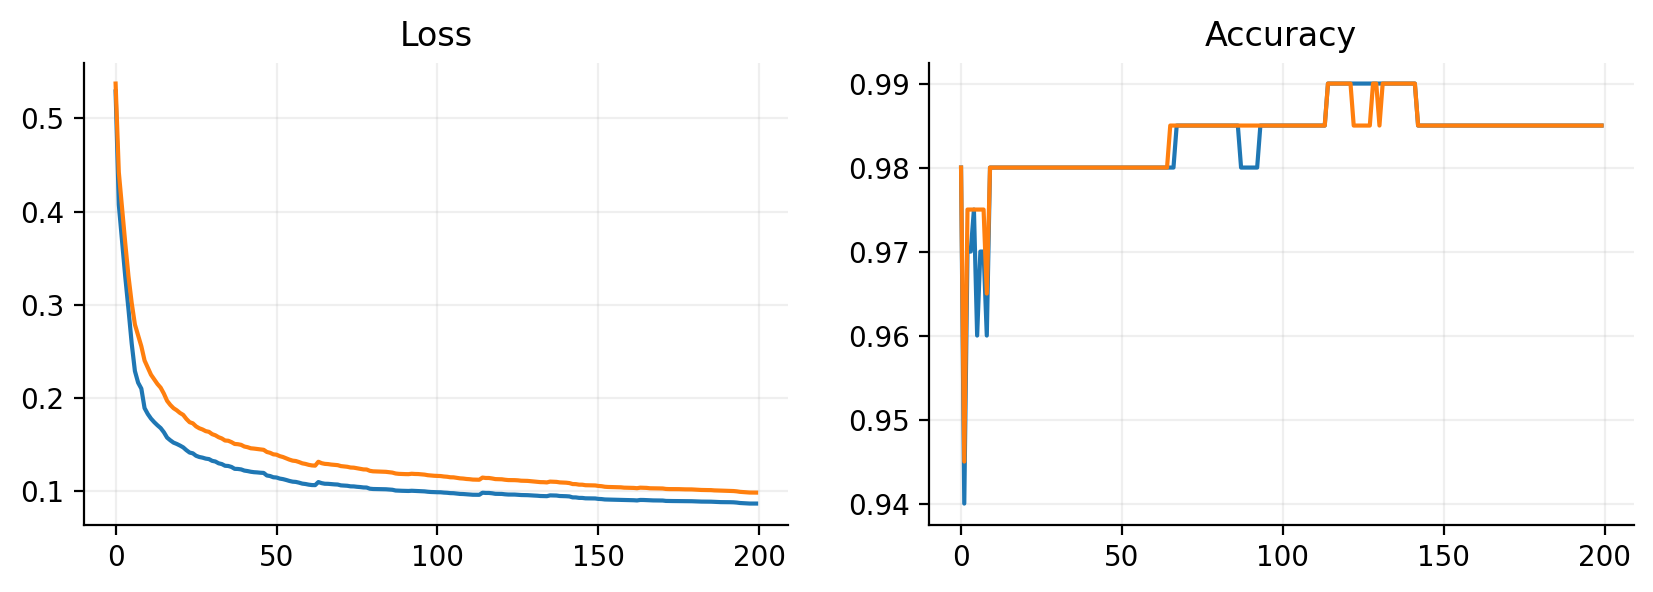

In [431]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3)) 

ax[0].plot(hist_loss)
ax[0].plot(hist_loss_ekf)

ax[0].grid(alpha=0.2)
ax[0].set_title("Loss")

ax[1].plot(hist_acc)
ax[1].plot(hist_acc_ekf)
ax[1].grid(alpha=0.2)
ax[1].set_title("Accuracy")